In [1]:
# Import necessary libraries
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Configure database connection
db_config = {
    'user': 'root',
    'password': 'LZ#amhe!32',
    'host': '127.0.0.1',
    'database': 'fyp1',
    'raise_on_warnings': True
}

In [3]:
# Connect to the database
try:
    conn = mysql.connector.connect(**db_config)
    print("Database connection successful!")
    cursor = conn.cursor(dictionary=True)
except Exception as e:
    print(f"Error connecting to database: {e}")
    raise

Database connection successful!


In [4]:
# Function to execute and display query results
def execute_query(query, description="Query results"):
    try:
        cursor.execute(query)
        results = cursor.fetchall()
        if results:
            df = pd.DataFrame(results)
            print(f"\n{description} ({len(results)} rows):")
            return df
        else:
            print(f"\n{description}: No results found.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error executing query: {e}")
        return pd.DataFrame()

In [23]:
# Population Data Validation and Analysis

In [5]:
# Define the country exclusion set with the specific country IDs to exclude
country_exclusion_set = {299,298,297,296,295,291,289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 239, 238}

In [6]:
# Create the SQL filter to exclude these country IDs
standard_country_filter = f"AND p.country_id NOT IN ({','.join(map(str, country_exclusion_set))})"

print(f"\nExclusion set contains {len(country_exclusion_set)} non-standard entries (regions/aggregates)")

# Retrieve a sample of excluded countries to verify
excluded_countries = execute_query(
    """
    SELECT country_id, country_name, country_code
    FROM Countries
    WHERE country_id IN ({})
    LIMIT 10
    """.format(','.join(map(str, country_exclusion_set))),
    "Sample of excluded non-standard entries"
)


Exclusion set contains 57 non-standard entries (regions/aggregates)

Sample of excluded non-standard entries (10 rows):


In [7]:
# 1. Check if Population table has data
population_count = execute_query(
    "SELECT COUNT(*) as count FROM Population", 
    "Total Population table record count"
)

# Display the value of population_count
if not population_count.empty:
    print(f"Total Population table record count: {population_count.iloc[0]['count']}")
else:
    print("No data found in the Population table.")

# Check population count for standard countries only
if standard_country_filter:
    std_population_count = execute_query(
        f"SELECT COUNT(*) as count FROM Population p WHERE 1=1 {standard_country_filter}", 
        "Population table record count (standard countries only)"
    )
if not std_population_count.empty:
    print(f"standard countries Population table record count: {std_population_count.iloc[0]['count']}")
else:
    print("No data found in the Population table.")


Total Population table record count (1 rows):
Total Population table record count: 88967

Population table record count (standard countries only) (1 rows):
standard countries Population table record count: 84746


In [8]:
# 2. Check data sources
data_sources = execute_query(
    "SELECT * FROM Data_Sources", 
    "Data Sources"
)
print(data_sources)
# Check how many sources provide population data
population_by_source = execute_query(
    """
    SELECT source_id, COUNT(*) as record_count 
    FROM Population 
    GROUP BY source_id
    """,
    "Population records by source"
)
print(population_by_source)

# Add a note about handling duplicate records from multiple sources
print("\nNote: Population data may be present twice, once from each data source.")
print("The following analysis will consider this when displaying and analyzing the data.")


Data Sources (6 rows):
   source_id                                name  \
0          1  United Nations Population Division   
1          2                          World Bank   
2          3                            Eurostat   
3          4                       Census Bureau   
4          5                       GM-Population   
5          6                                OECD   

                                             website  
0                          https://population.un.org  
1                         https://data.worldbank.org  
2                      https://ec.europa.eu/eurostat  
3                             https://www.census.gov  
4  https://www.gapminder.org/data/documentation/g...  
5                       https://www.oecd.org/en.html  

Population records by source (6 rows):
   source_id  record_count
0          1         21660
1          2         13858
2          3          2589
3          4         17025
4          5         29747
5          6          40

In [9]:
# 3. Check countries count
countries_count = execute_query(
    "SELECT COUNT(*) as count FROM Countries", 
    "Countries record count"
)
print(f"Total Countries record count: {countries_count.iloc[0]['count']}")


Countries record count (1 rows):
Total Countries record count: 299


In [10]:
# 4. Sample data from Population table (standard countries only)
population_sample = execute_query(
    f"""
    SELECT p.country_id, c.country_name, c.country_code, p.year, p.population, p.last_updated 
    FROM Population p
    JOIN Countries c ON p.country_id = c.country_id
    WHERE 1=1 {standard_country_filter}
    ORDER BY c.country_name, p.year
    LIMIT 20
    """,
    "Sample records from Population table (standard countries only)"
)
print(population_sample)


Sample records from Population table (standard countries only) (20 rows):
    country_id country_name country_code  year  population        last_updated
0            1  Afghanistan          AFG  1800     3280000 2025-03-23 22:11:24
1            1  Afghanistan          AFG  1801     3280000 2025-03-23 22:11:24
2            1  Afghanistan          AFG  1802     3280000 2025-03-23 22:11:24
3            1  Afghanistan          AFG  1803     3280000 2025-03-23 22:11:24
4            1  Afghanistan          AFG  1804     3280000 2025-03-23 22:11:24
5            1  Afghanistan          AFG  1805     3280000 2025-03-23 22:11:24
6            1  Afghanistan          AFG  1806     3280000 2025-03-23 22:11:24
7            1  Afghanistan          AFG  1807     3280000 2025-03-23 22:11:24
8            1  Afghanistan          AFG  1808     3280000 2025-03-23 22:11:24
9            1  Afghanistan          AFG  1809     3280000 2025-03-23 22:11:24
10           1  Afghanistan          AFG  1810     32800

In [11]:
# 5. Check year range coverage
year_range = execute_query(
    f"""
    SELECT MIN(year) as min_year, MAX(year) as max_year
    FROM Population p
    WHERE 1=1 {standard_country_filter}
    """,
    "Year range in Population data"
)
print(f"Year range in Population data: {year_range.iloc[0]['min_year']} to {year_range.iloc[0]['max_year']}")


Year range in Population data (1 rows):
Year range in Population data: 1800 to 2025



Population data for USA from all sources (225 rows):
No missing years for USA in the range 1941-2025


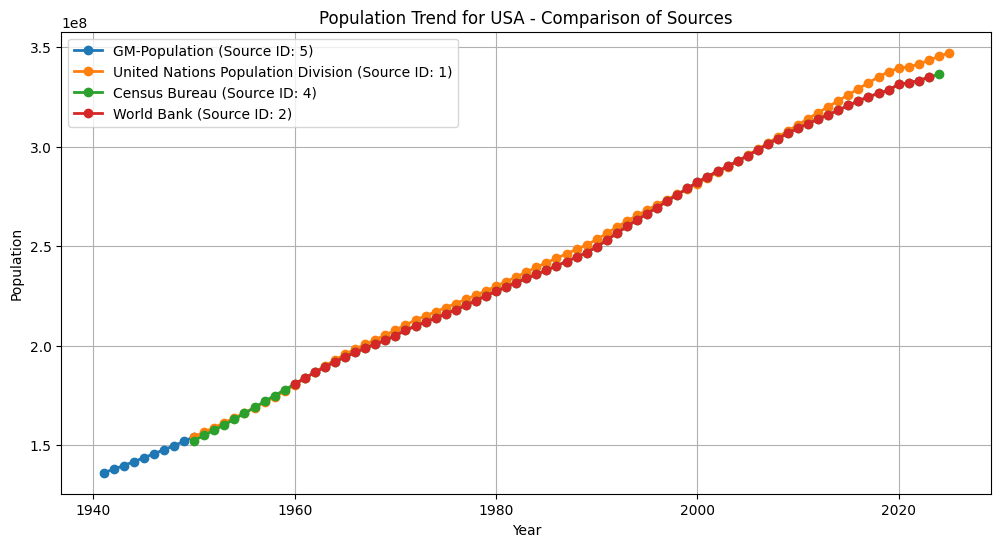

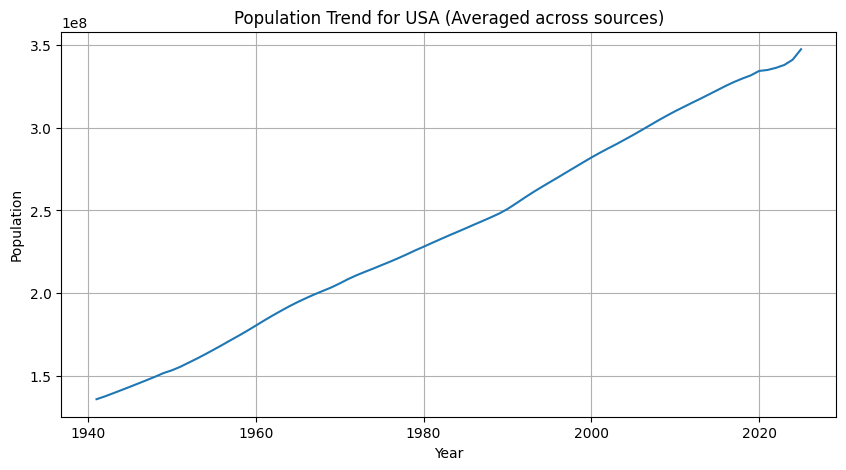


Population data for CHN from all sources (225 rows):
No missing years for CHN in the range 1941-2025


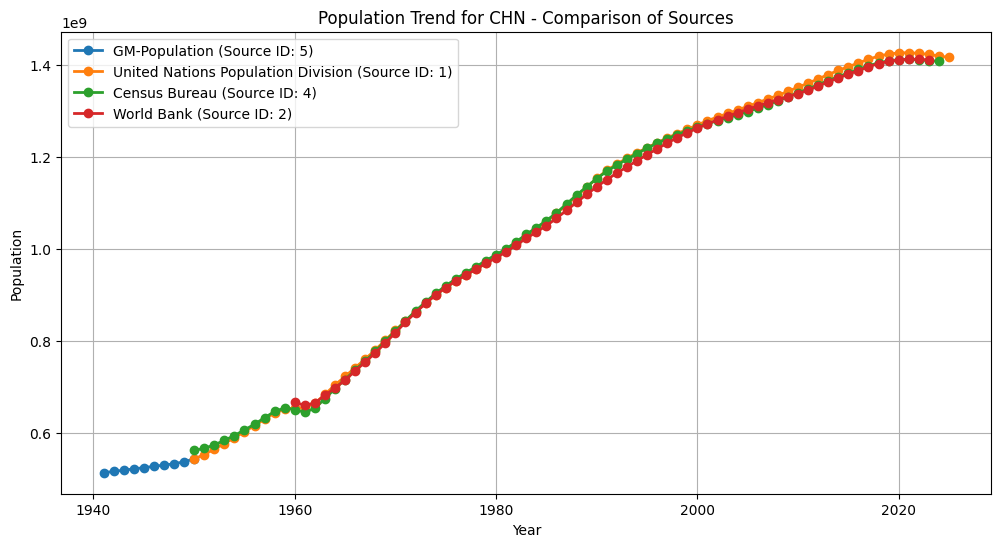

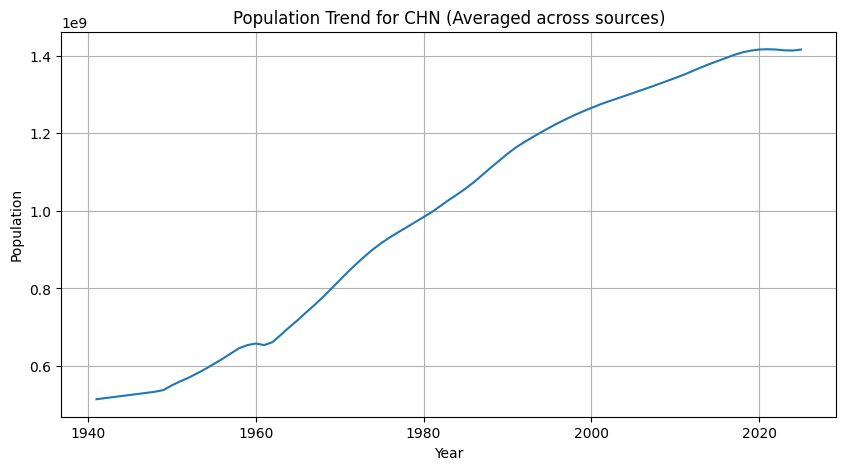


Population data for IND from all sources (225 rows):
No missing years for IND in the range 1941-2025


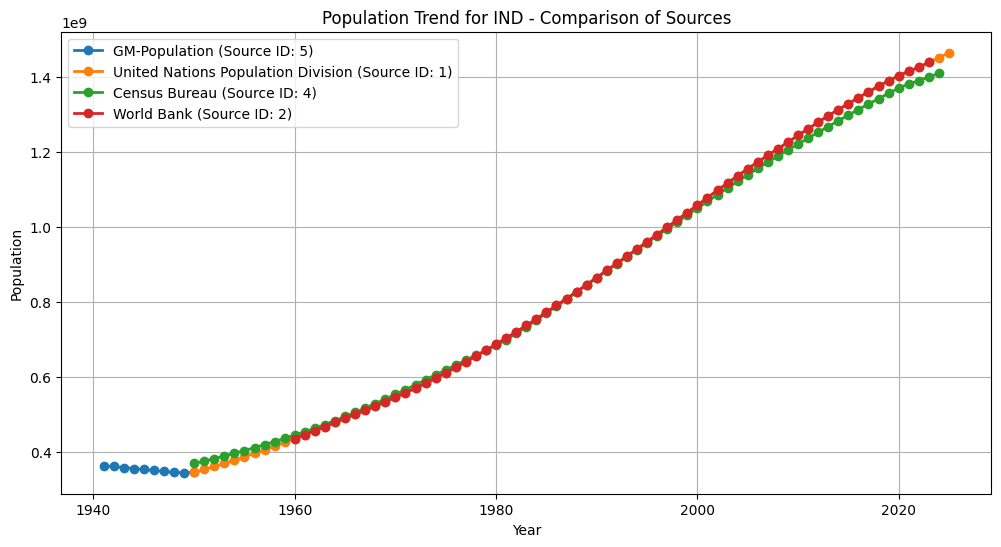

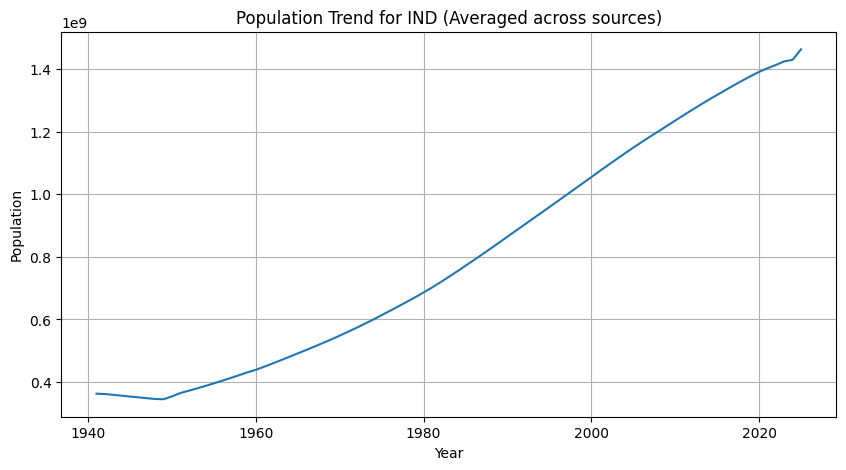


Population data for GBR from all sources (286 rows):
No missing years for GBR in the range 1941-2025


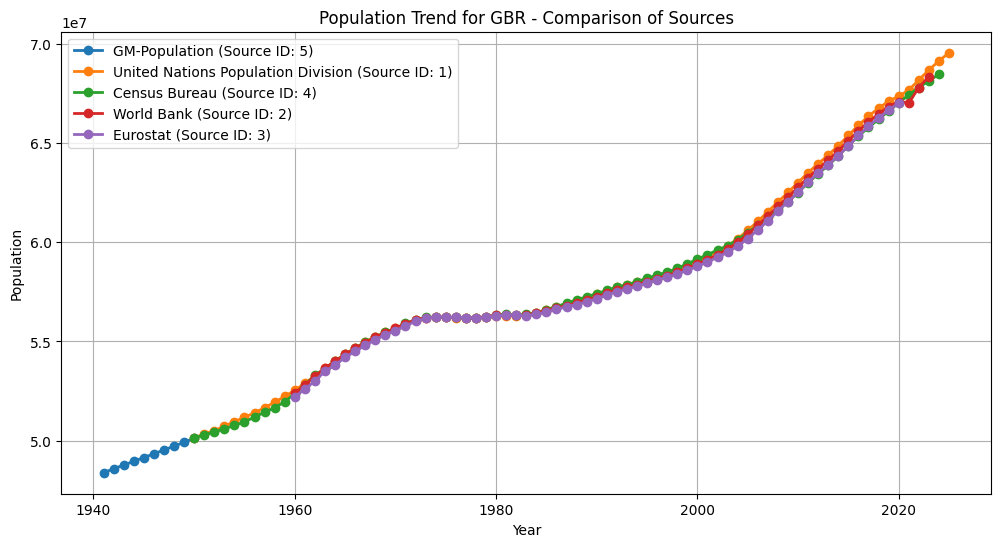

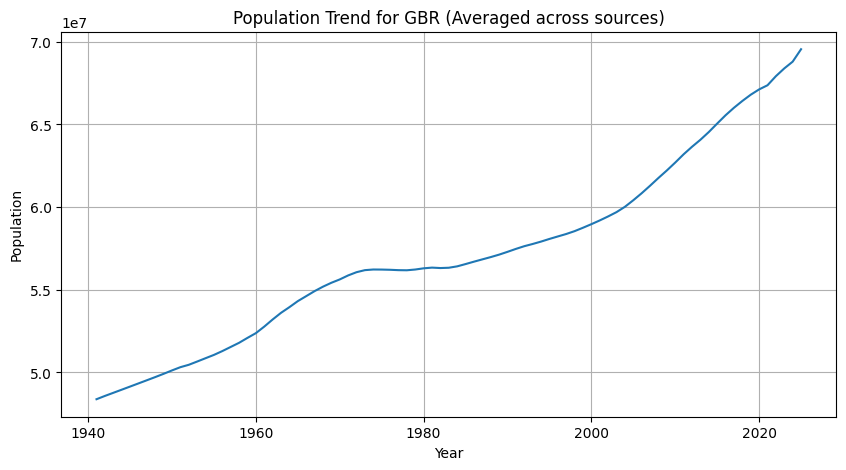


Population data for FRA from all sources (259 rows):
No missing years for FRA in the range 1941-2025


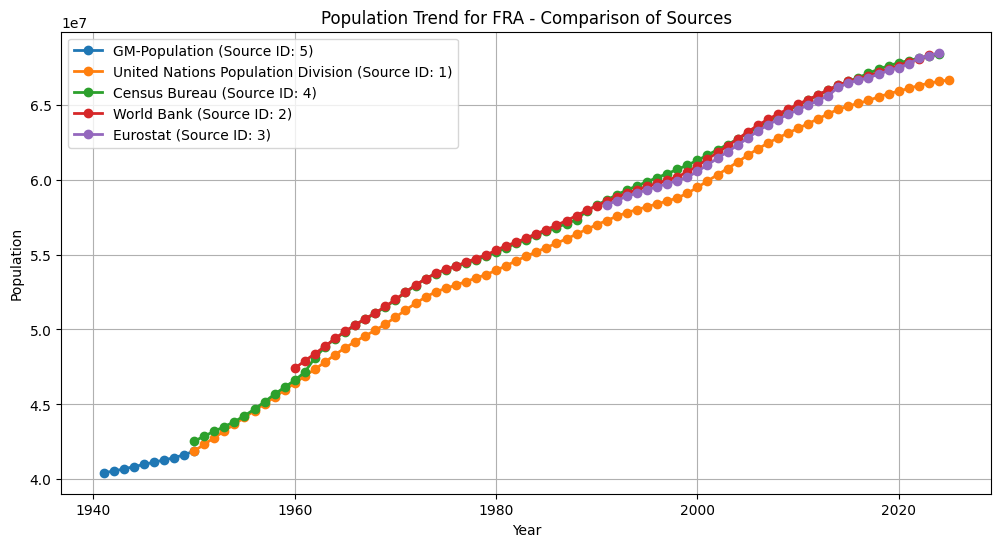

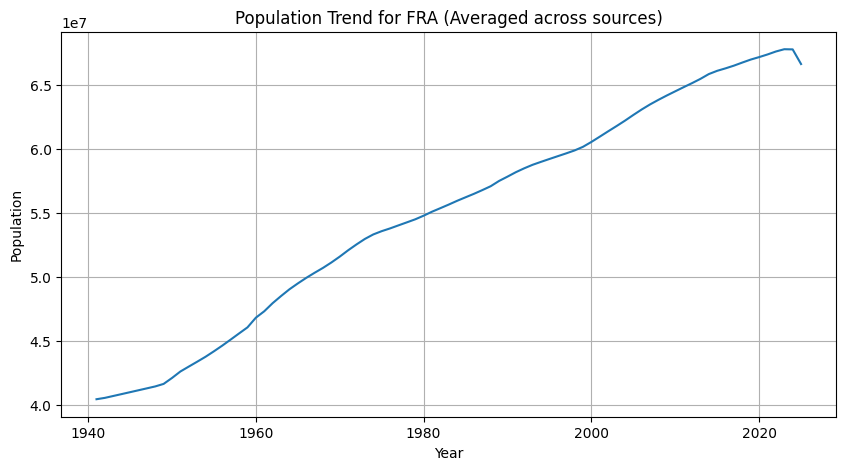


Population data for DEU from all sources (290 rows):
No missing years for DEU in the range 1941-2025


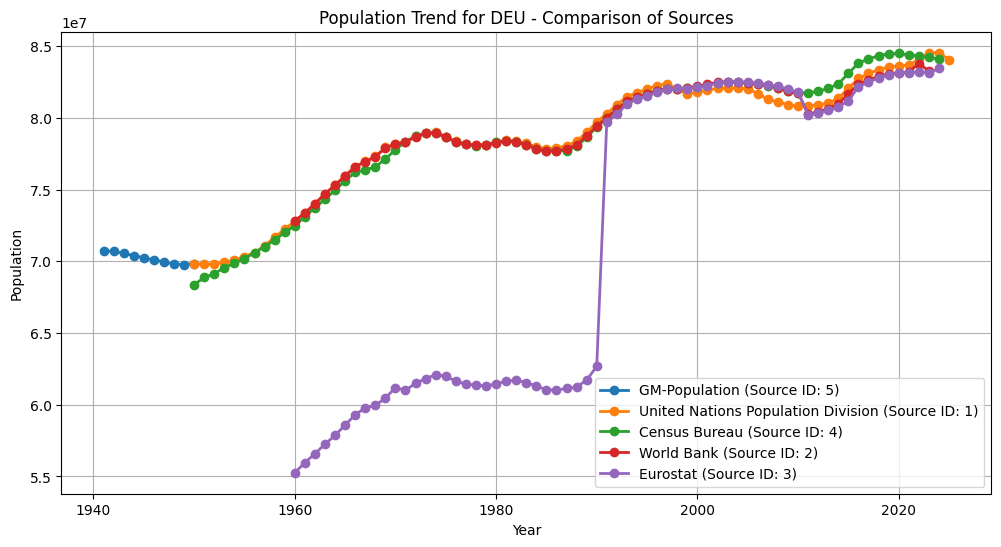

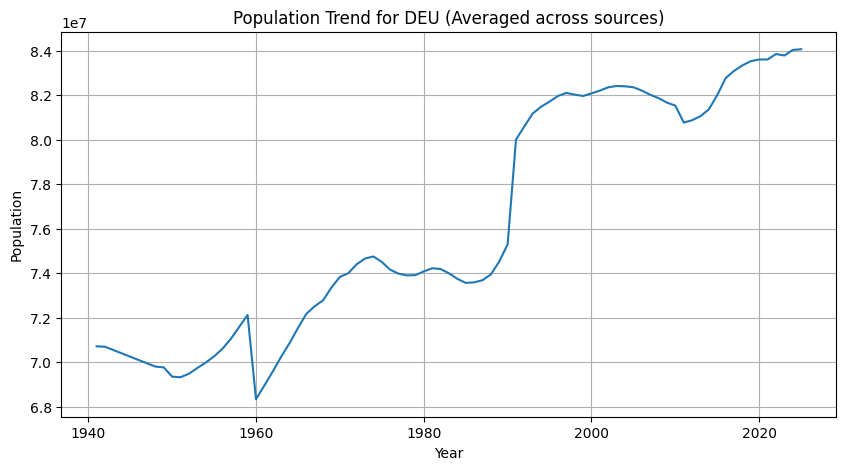


Population data for JPN from all sources (225 rows):
No missing years for JPN in the range 1941-2025


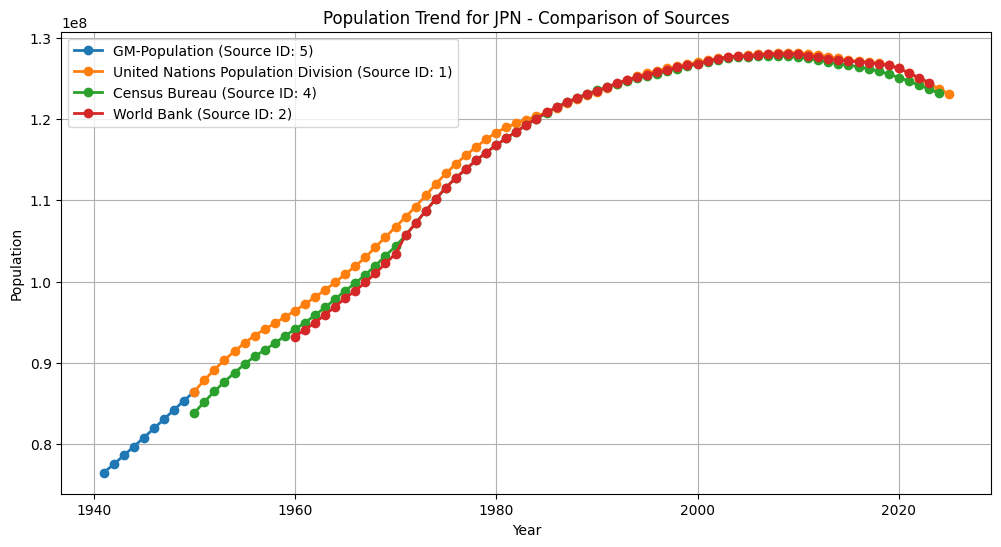

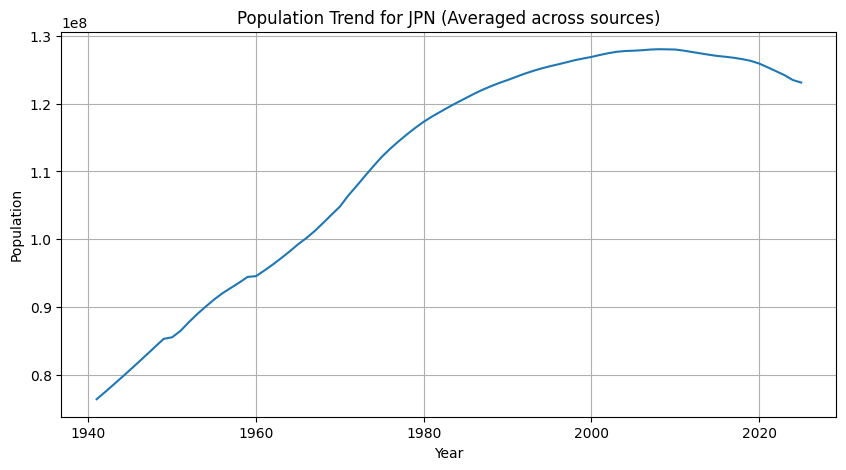


Population data for PSE from all sources (120 rows):
No missing years for PSE in the range 1941-2025


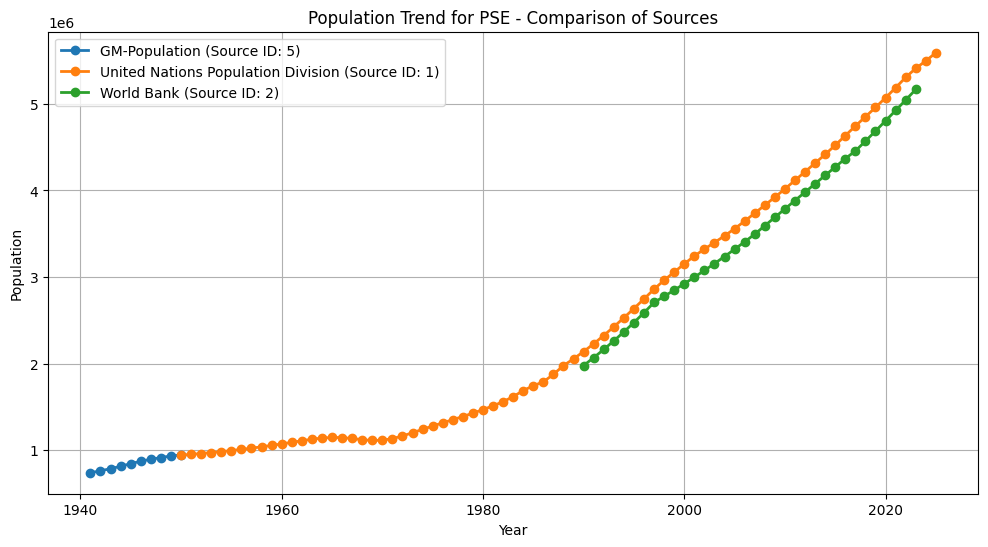

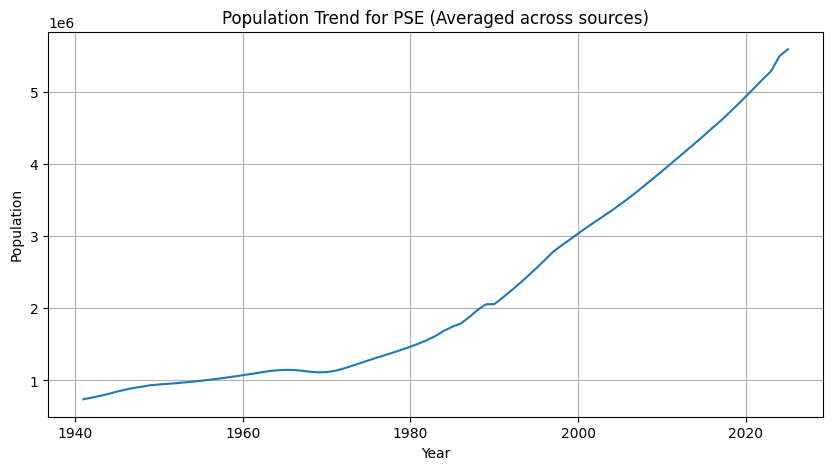


Population data for ISR from all sources (225 rows):
No missing years for ISR in the range 1941-2025


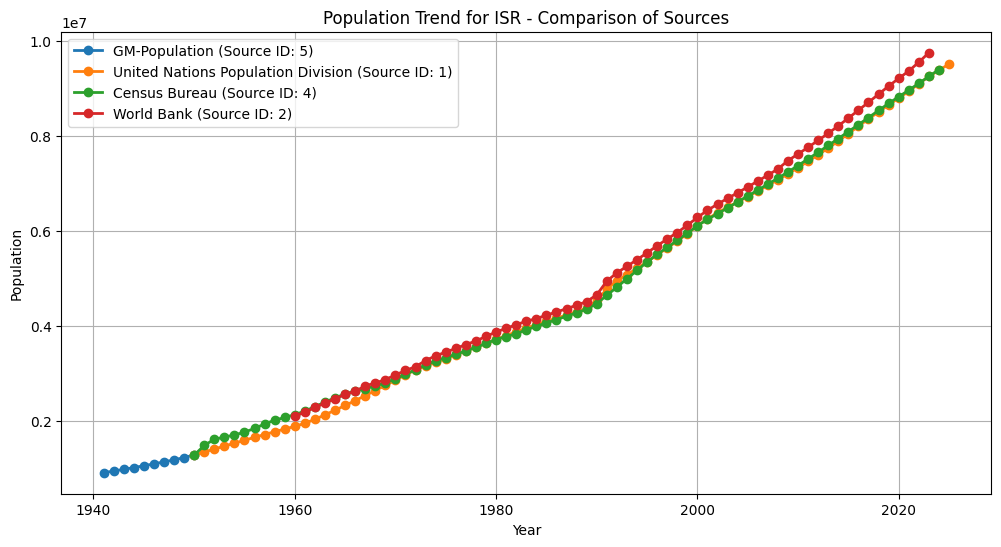

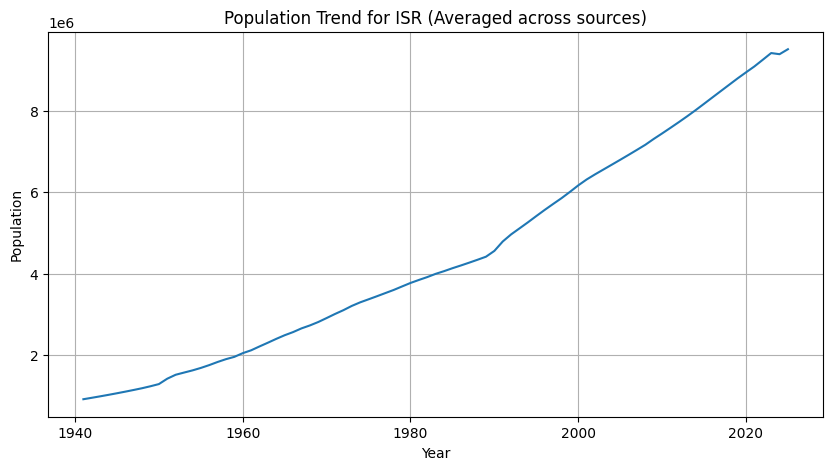

In [14]:
# 6. Check for missing years or gaps in the data for specific countries
# Let's check a few major countries as examples
countries_to_check = ['USA', 'CHN', 'IND', 'GBR', 'FRA', 'DEU', 'JPN','PSE','ISR']

for country_code in countries_to_check:
    # Get data from both sources for comparison
    df_all_sources = execute_query(
        f"""
        SELECT p.year, p.population, p.source_id, s.name as source_name
        FROM Population p
        JOIN Countries c ON p.country_id = c.country_id
        JOIN Data_Sources s ON p.source_id = s.source_id
        WHERE c.country_code = '{country_code}' and p.source_id != 6 and p.year > 1940
        ORDER BY p.year, p.source_id
        """,
        f"Population data for {country_code} from all sources"
    )
    
    if df_all_sources.empty:
        print(f"No data found for country {country_code}")
        continue
    
    # Identify available sources
    available_sources = df_all_sources['source_id'].unique()
    
    # Get aggregated data (to avoid duplicates in analysis)
    # For each year, we'll average the population values across sources
    df = df_all_sources.groupby('year')['population'].mean().reset_index()
    
    if not df.empty:
        # Check for missing years in the range
        years = df['year'].astype(int).tolist()
        expected_years = list(range(min(years), max(years) + 1))
        missing_years = [year for year in expected_years if year not in years]
        
        if missing_years:
            print(f"Missing years for {country_code}: {missing_years}")
        else:
            print(f"No missing years for {country_code} in the range {min(years)}-{max(years)}")
        
        # For a visual comparison of sources, create a plot with both sources
        if len(available_sources) > 1:
            plt.figure(figsize=(12, 6))
            
            # Plot data from each source separately
            for source_id in available_sources:
                source_data = df_all_sources[df_all_sources['source_id'] == source_id]
                source_name = source_data['source_name'].iloc[0] if not source_data.empty else f"Source {source_id}"
                plt.plot(source_data['year'], source_data['population'], marker='o', linewidth=2, 
                         label=f"{source_name} (Source ID: {source_id})")
            
            plt.title(f'Population Trend for {country_code} - Comparison of Sources')
            plt.xlabel('Year')
            plt.ylabel('Population')
            plt.grid(True)
            plt.legend()
            plt.show()
        
        # Plot the aggregated trend (average of sources)
        plt.figure(figsize=(10, 5))
        plt.plot(df['year'], df['population'])
        plt.title(f'Population Trend for {country_code} (Averaged across sources)')
        plt.xlabel('Year')
        plt.ylabel('Population')
        plt.grid(True)
        plt.show()



Population data for USA from all sources (439 rows):
No missing years for USA in the range 1800-2025


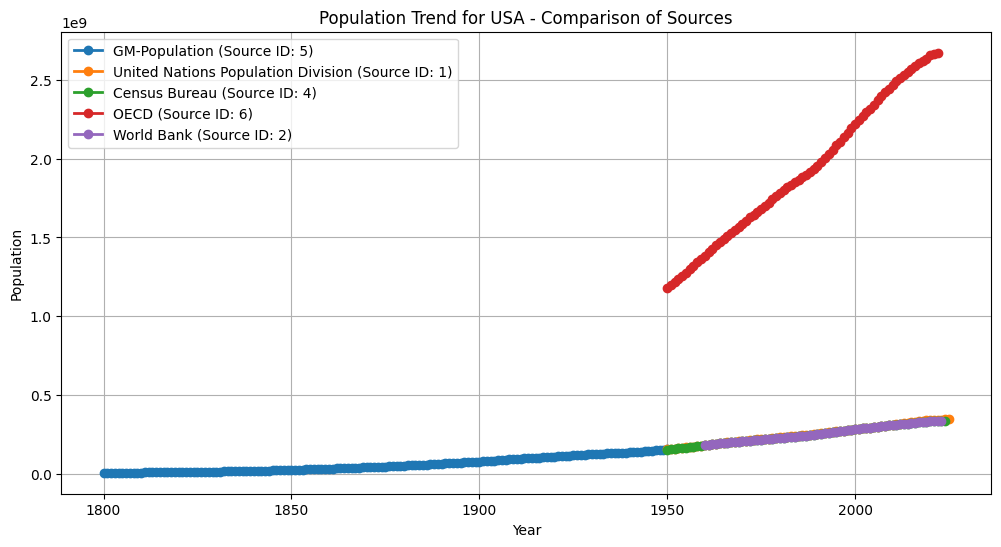

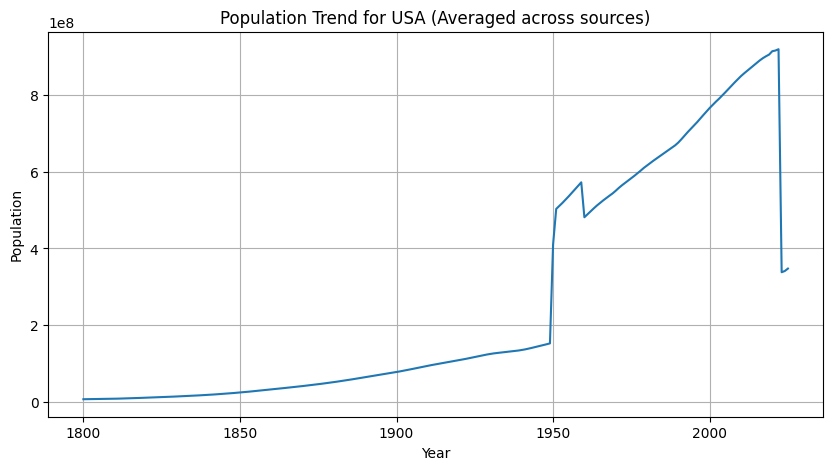


Population data for CHN from all sources (439 rows):
No missing years for CHN in the range 1800-2025


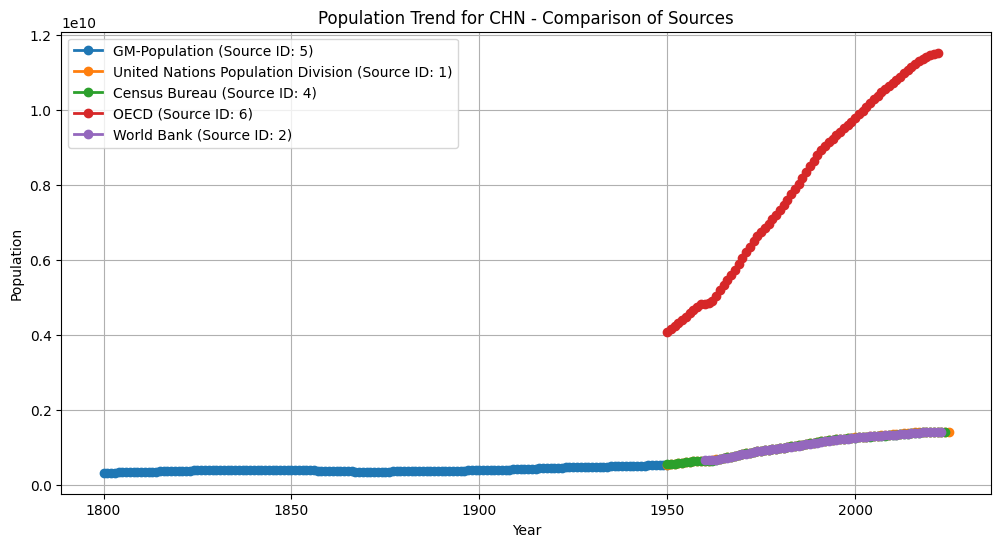

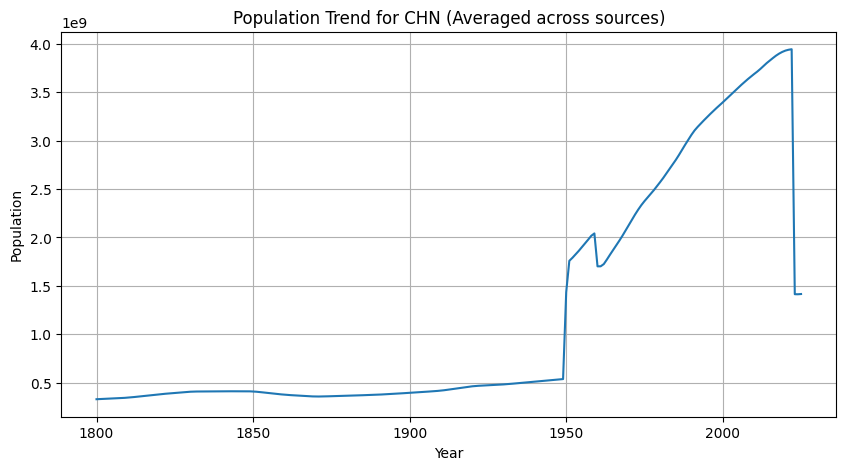


Population data for IND from all sources (439 rows):
No missing years for IND in the range 1800-2025


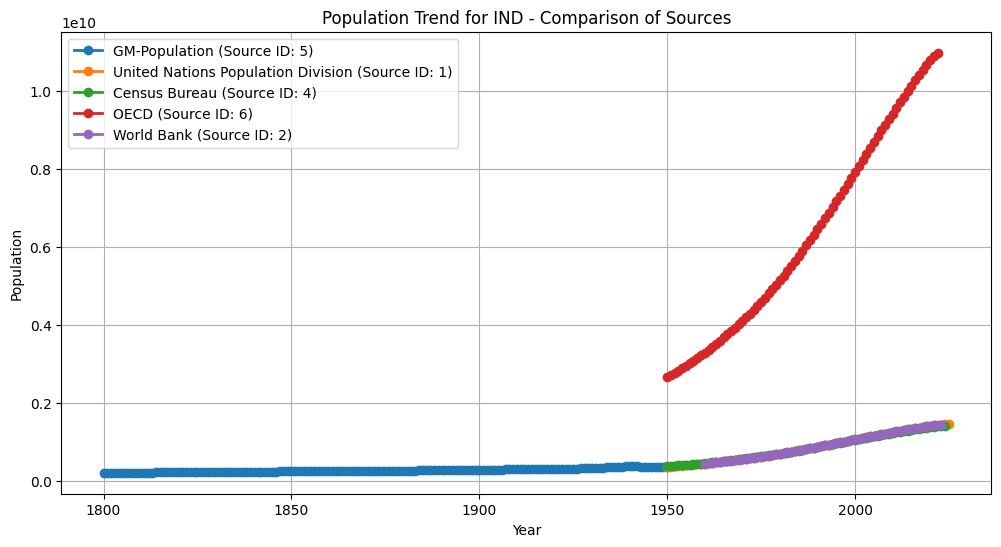

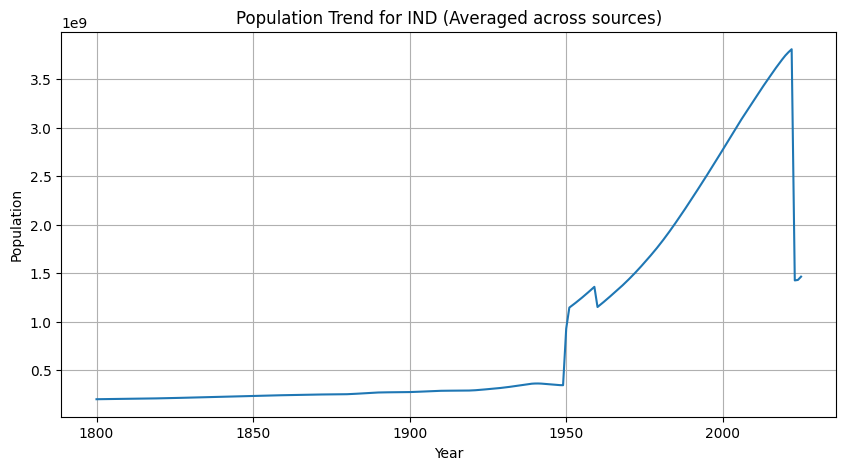


Population data for GBR from all sources (500 rows):
No missing years for GBR in the range 1800-2025


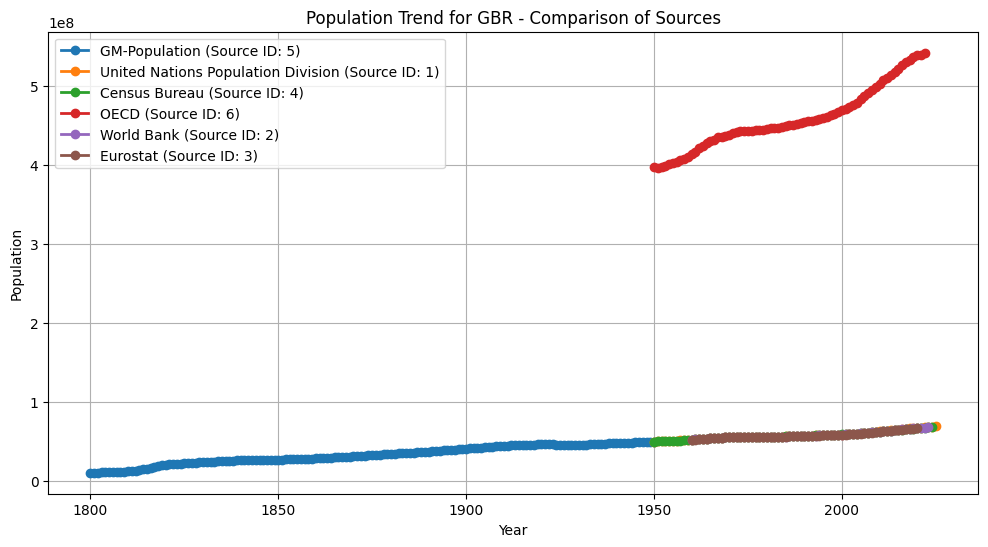

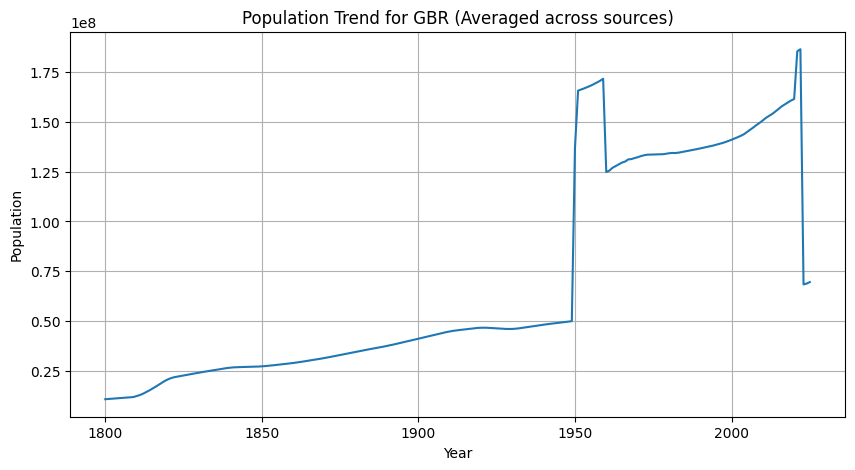


Population data for FRA from all sources (473 rows):
No missing years for FRA in the range 1800-2025


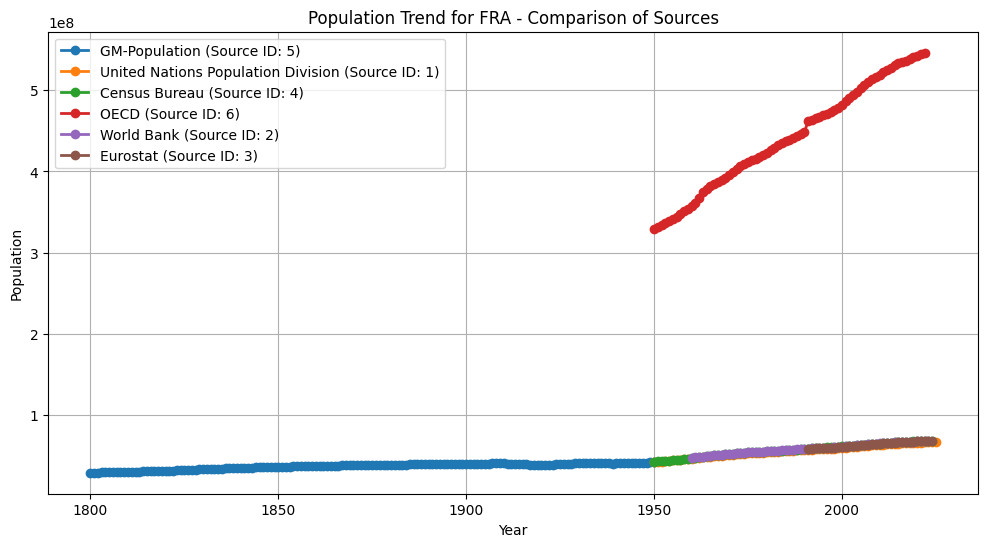

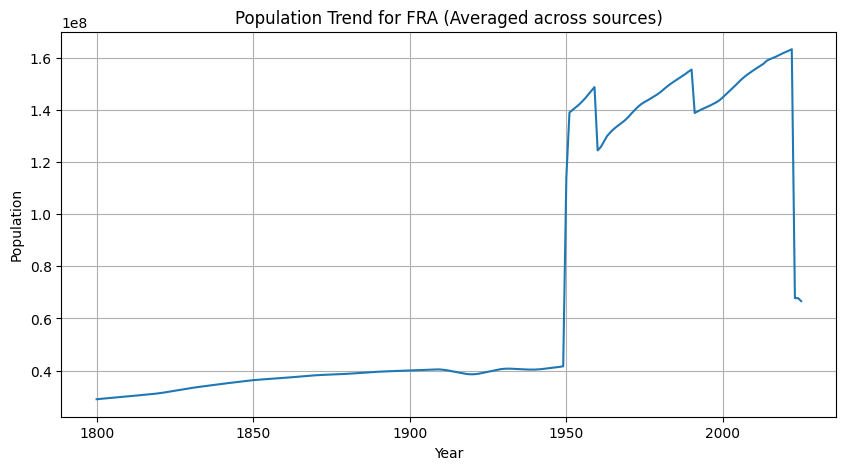


Population data for DEU from all sources (504 rows):
No missing years for DEU in the range 1800-2025


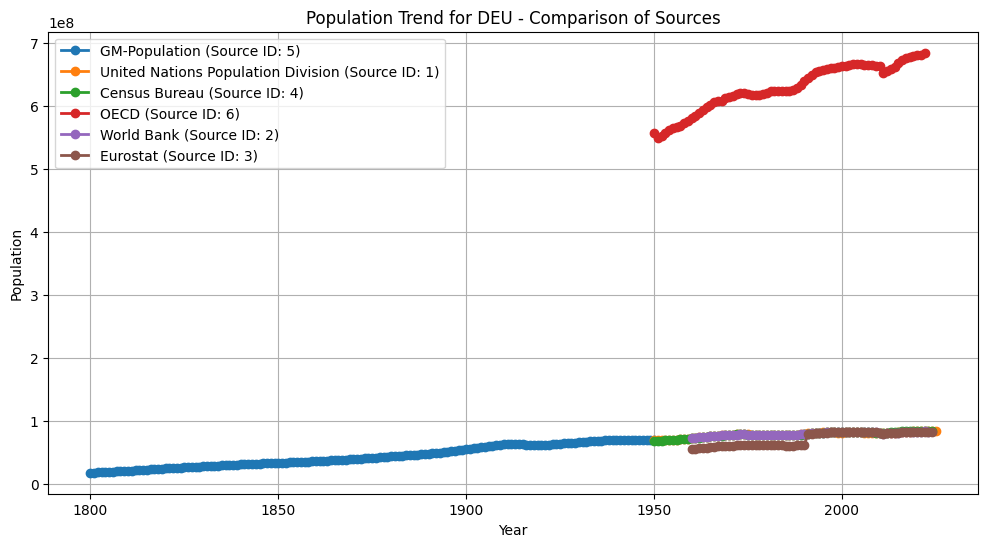

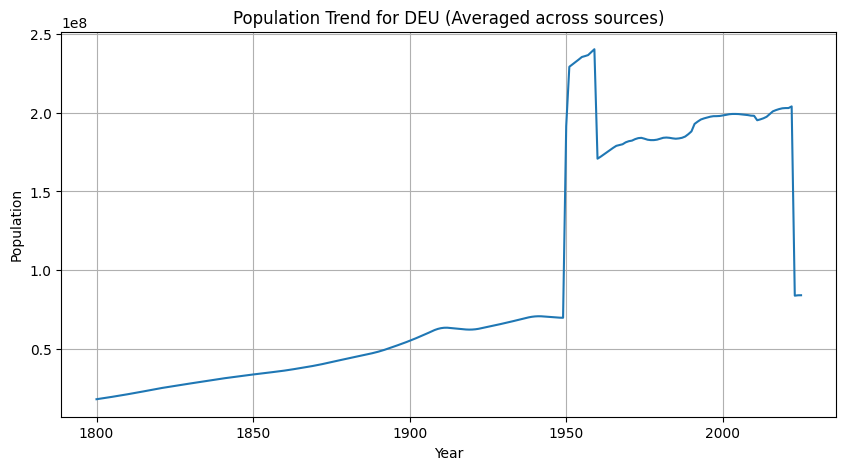


Population data for JPN from all sources (439 rows):
No missing years for JPN in the range 1800-2025


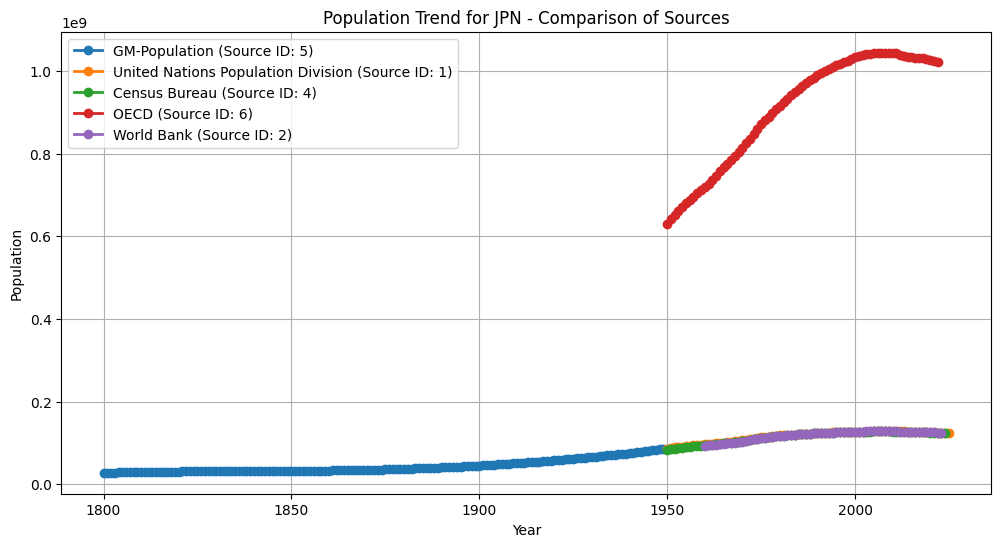

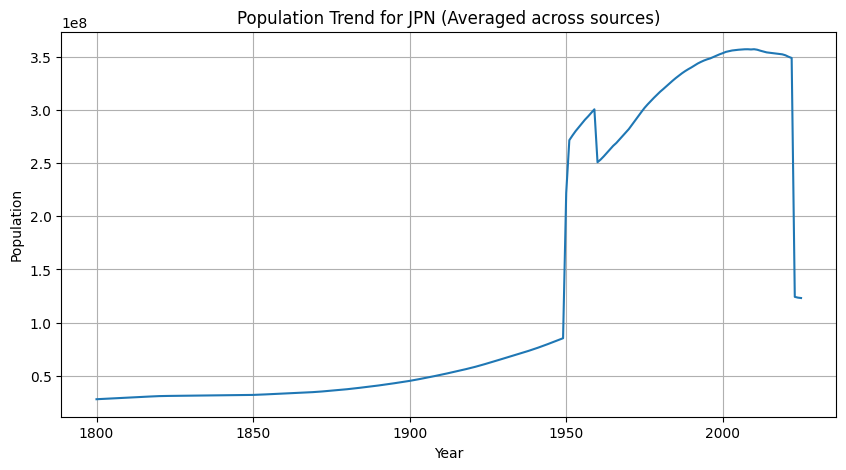


Population data for ISR from all sources (439 rows):
No missing years for ISR in the range 1800-2025


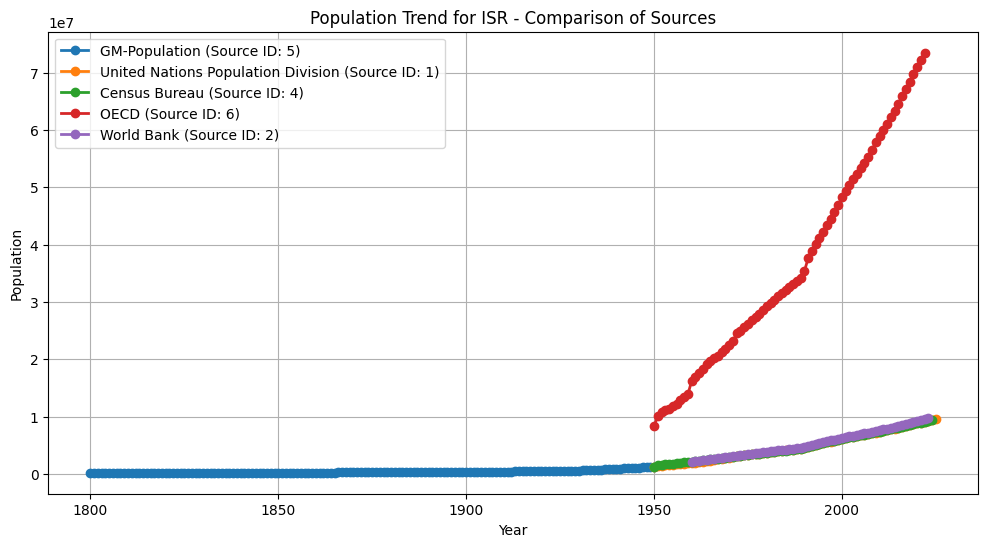

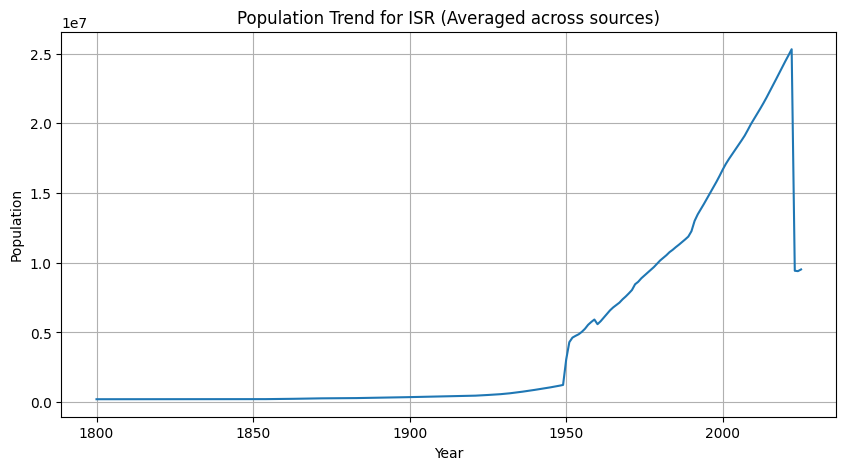


Population data for RUS from all sources (453 rows):
No missing years for RUS in the range 1800-2025


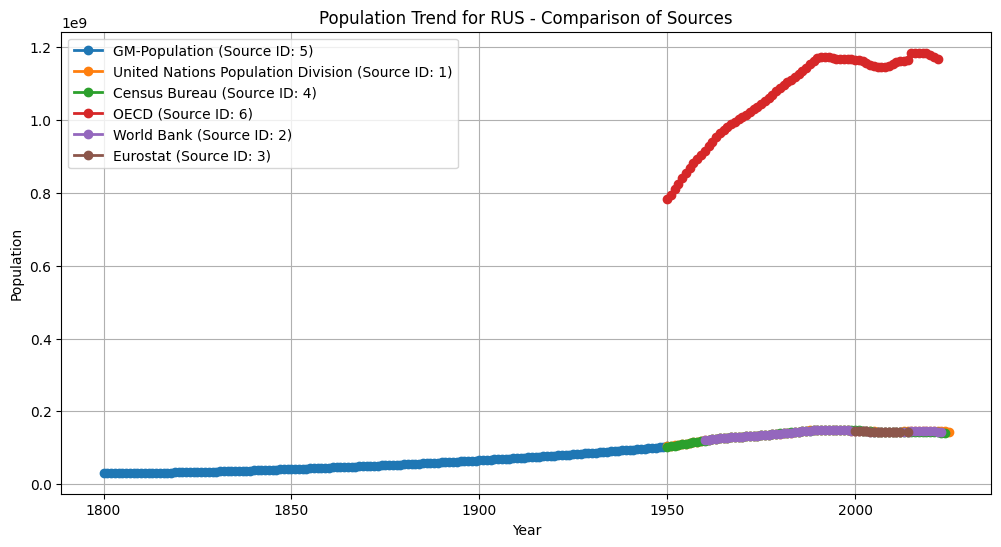

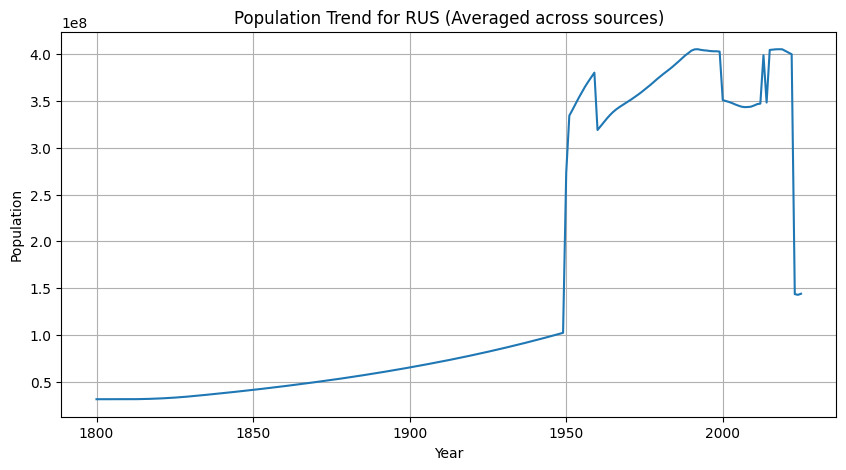


===== Special Analysis for Palestine (PSE) =====
Note: For source ID 4, PSE data will be constructed by combining West Bank (292) and Gaza (294)

Direct Population data for Palestine (PSE) (261 rows):

Combined West Bank and Gaza data (Source 4) (75 rows):


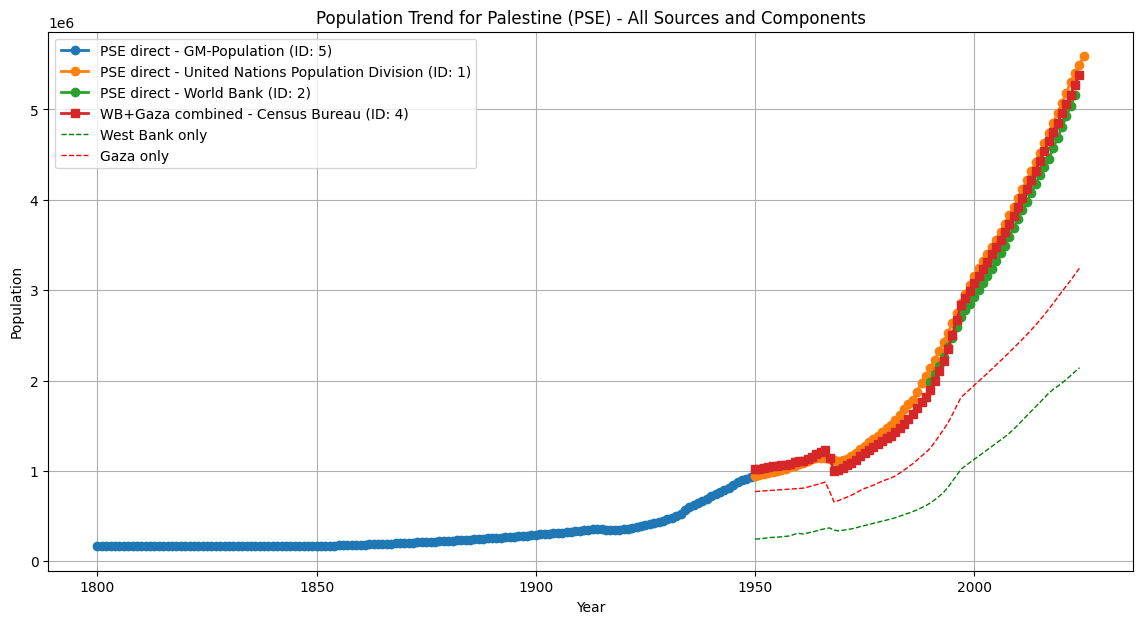


Summary statistics for PSE population data:
Direct PSE data: 165,944 (1800) → 5,589,623 (2025)
Combined WB+Gaza: 1,016,540 (1950) → 5,385,012 (2024)


In [15]:
# 6. Check for missing years or gaps in the data for specific countries
# Let's check a few major countries as examples
countries_to_check = ['USA', 'CHN', 'IND', 'GBR', 'FRA', 'DEU', 'JPN', 'ISR','RUS']

for country_code in countries_to_check:
    # Get data from both sources for comparison
    df_all_sources = execute_query(
        f"""
        SELECT p.year, p.population, p.source_id, s.name as source_name
        FROM Population p
        JOIN Countries c ON p.country_id = c.country_id
        JOIN Data_Sources s ON p.source_id = s.source_id
        WHERE c.country_code = '{country_code}'
        ORDER BY p.year, p.source_id
        """,
        f"Population data for {country_code} from all sources"
    )
    
    if df_all_sources.empty:
        print(f"No data found for country {country_code}")
        continue
    
    # Identify available sources
    available_sources = df_all_sources['source_id'].unique()
    
    # Get aggregated data (to avoid duplicates in analysis)
    # For each year, we'll average the population values across sources
    df = df_all_sources.groupby('year')['population'].mean().reset_index()
    
    if not df.empty:
        # Check for missing years in the range
        years = df['year'].astype(int).tolist()
        expected_years = list(range(min(years), max(years) + 1))
        missing_years = [year for year in expected_years if year not in years]
        
        if missing_years:
            print(f"Missing years for {country_code}: {missing_years}")
        else:
            print(f"No missing years for {country_code} in the range {min(years)}-{max(years)}")
        
        # For a visual comparison of sources, create a plot with both sources
        if len(available_sources) > 1:
            plt.figure(figsize=(12, 6))
            
            # Plot data from each source separately
            for source_id in available_sources:
                source_data = df_all_sources[df_all_sources['source_id'] == source_id]
                source_name = source_data['source_name'].iloc[0] if not source_data.empty else f"Source {source_id}"
                plt.plot(source_data['year'], source_data['population'], marker='o', linewidth=2, 
                         label=f"{source_name} (Source ID: {source_id})")
            
            plt.title(f'Population Trend for {country_code} - Comparison of Sources')
            plt.xlabel('Year')
            plt.ylabel('Population')
            plt.grid(True)
            plt.legend()
            plt.show()
        
        # Plot the aggregated trend (average of sources)
        plt.figure(figsize=(10, 5))
        plt.plot(df['year'], df['population'])
        plt.title(f'Population Trend for {country_code} (Averaged across sources)')
        plt.xlabel('Year')
        plt.ylabel('Population')
        plt.grid(True)
        plt.show()

# Special case for Palestine (PSE)
print("\n===== Special Analysis for Palestine (PSE) =====")
print("Note: For source ID 4, PSE data will be constructed by combining West Bank (292) and Gaza (294)")

# First, get the data for PSE from sources that have it directly
pse_direct = execute_query(
    """
    SELECT p.year, p.population, p.source_id, s.name as source_name
    FROM Population p
    JOIN Countries c ON p.country_id = c.country_id
    JOIN Data_Sources s ON p.source_id = s.source_id
    WHERE c.country_code = 'PSE'
    ORDER BY p.year, p.source_id
    """,
    "Direct Population data for Palestine (PSE)"
)

# Get data for West Bank (292) and Gaza (294) from source 4
wb_gaza = execute_query(
    """
    SELECT 
        wb.year, 
        wb.population as wb_population,
        gz.population as gaza_population,
        (wb.population + gz.population) as combined_population,
        wb.source_id,
        s.name as source_name
    FROM Population wb
    JOIN Population gz ON wb.year = gz.year AND wb.source_id = gz.source_id
    JOIN Data_Sources s ON wb.source_id = s.source_id
    WHERE wb.country_id = 292
    AND gz.country_id = 294
    AND wb.source_id = 4
    ORDER BY wb.year
    """,
    "Combined West Bank and Gaza data (Source 4)"
)

# Combine the two datasets
if not pse_direct.empty or not wb_gaza.empty:
    # Create figure for comparison
    plt.figure(figsize=(14, 7))
    
    # Plot direct PSE data if available
    if not pse_direct.empty:
        for source_id in pse_direct['source_id'].unique():
            source_data = pse_direct[pse_direct['source_id'] == source_id]
            source_name = source_data['source_name'].iloc[0]
            plt.plot(source_data['year'], source_data['population'], marker='o', 
                    linewidth=2, label=f"PSE direct - {source_name} (ID: {source_id})")
    
    # Plot combined WB+Gaza data if available
    if not wb_gaza.empty:
        plt.plot(wb_gaza['year'], wb_gaza['combined_population'], marker='s', 
                linewidth=2, label=f"WB+Gaza combined - {wb_gaza['source_name'].iloc[0]} (ID: 4)")
        
        # Also plot the components individually
        plt.plot(wb_gaza['year'], wb_gaza['wb_population'], 'g--', linewidth=1, 
                label="West Bank only")
        plt.plot(wb_gaza['year'], wb_gaza['gaza_population'], 'r--', linewidth=1, 
                label="Gaza only")
    
    plt.title('Population Trend for Palestine (PSE) - All Sources and Components')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Summary statistics
    print("\nSummary statistics for PSE population data:")
    
    if not pse_direct.empty:
        latest_year_direct = pse_direct['year'].max()
        latest_pop_direct = pse_direct[pse_direct['year'] == latest_year_direct]['population'].values[0]
        earliest_year_direct = pse_direct['year'].min()
        earliest_pop_direct = pse_direct[pse_direct['year'] == earliest_year_direct]['population'].values[0]
        
        print(f"Direct PSE data: {earliest_pop_direct:,.0f} ({earliest_year_direct}) → {latest_pop_direct:,.0f} ({latest_year_direct})")
    
    if not wb_gaza.empty:
        latest_year_combined = wb_gaza['year'].max()
        latest_pop_combined = wb_gaza[wb_gaza['year'] == latest_year_combined]['combined_population'].values[0]
        earliest_year_combined = wb_gaza['year'].min()
        earliest_pop_combined = wb_gaza[wb_gaza['year'] == earliest_year_combined]['combined_population'].values[0]
        
        print(f"Combined WB+Gaza: {earliest_pop_combined:,.0f} ({earliest_year_combined}) → {latest_pop_combined:,.0f} ({latest_year_combined})")
else:
    print("No data found for Palestine, West Bank, or Gaza")

Retrieving population data for Palestine...

Population data for Palestine (standard) (261 rows):

Population data for Palestine from source 4 (combined territories) (75 rows):

Available data sources (6 rows):

Calculating percentage differences between sources...


C:\Users\hlakk\AppData\Local\Temp\ipykernel_16864\1579986812.py:177: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_idx = diff_df[col].idxmax()
C:\Users\hlakk\AppData\Local\Temp\ipykernel_16864\1579986812.py:178: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  min_idx = diff_df[col].idxmin()


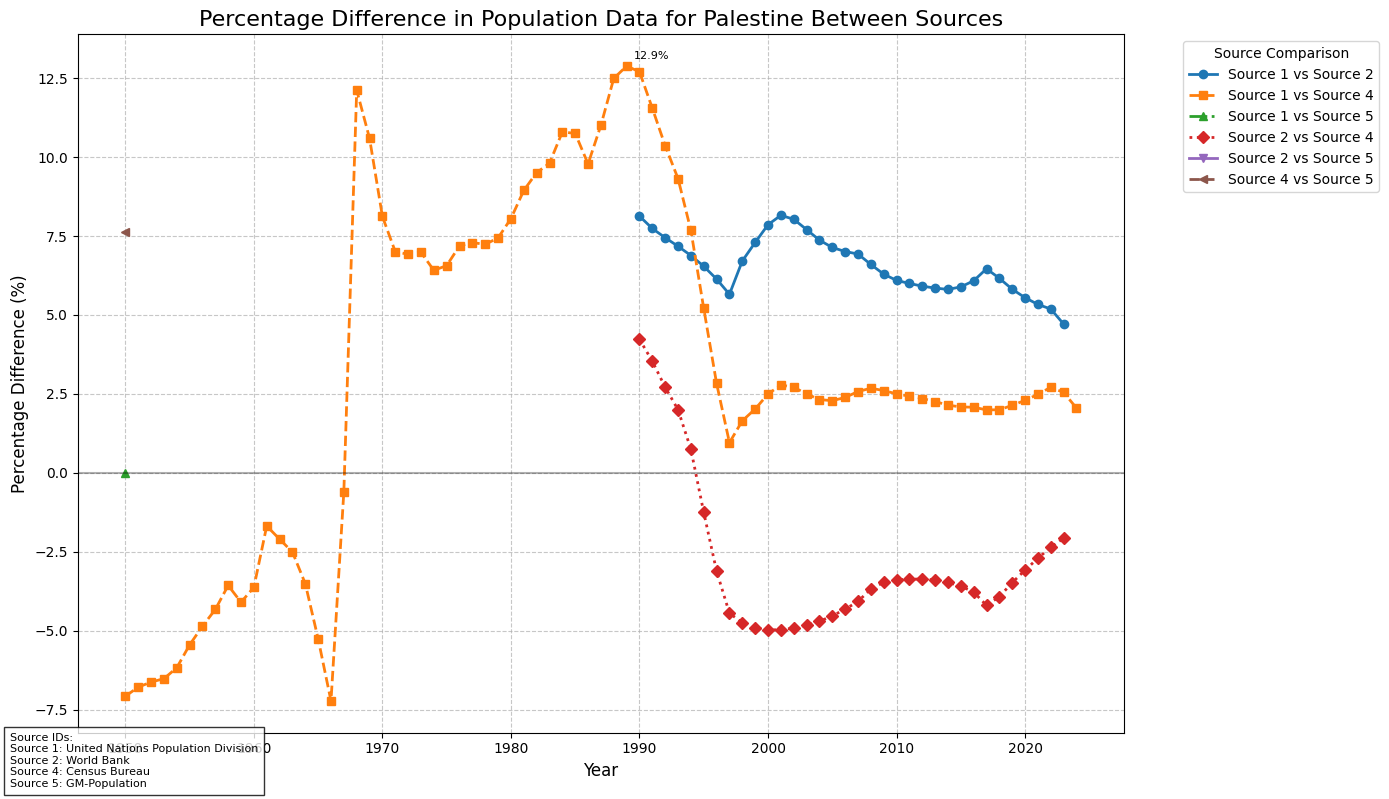


Raw Population Data for Palestine (in thousands or as stored in database):
       Source 1  Source 2   Source 4  Source 5
year                                          
1960  1073081.0       NaN  1113446.0       NaN
1961  1090928.0       NaN  1109603.0       NaN
1962  1109340.0       NaN  1133134.0       NaN
1963  1127468.0       NaN  1156474.0       NaN
1964  1140670.0       NaN  1182145.0       NaN
1965  1147310.0       NaN  1210960.0       NaN
1966  1146394.0       NaN  1235665.0       NaN
1967  1135820.0       NaN  1142636.0       NaN
1968  1121742.0       NaN  1000482.0       NaN
1969  1113086.0       NaN  1006458.0       NaN
1970  1116280.0       NaN  1032447.0       NaN

Summary statistics for percentage differences between sources:
       Source 1 vs Source 2  Source 1 vs Source 4  Source 1 vs Source 5  \
count             34.000000             75.000000                   1.0   
mean               6.578442              3.194923                   0.0   
std                0.905

In [16]:
# Palestine Population Data Comparison Analysis
# This code analyzes population data for Palestine across different data sources
# and calculates percentage differences between sources for each year

# Collect Palestine population data from all sources
print("Retrieving population data for Palestine...")

# Function to safely handle column names (in case database returns different column names)
def normalize_columns(df, expected_columns):
    """Normalize column names in case they come back differently from the database"""
    # Create a mapping of actual to expected column names (case-insensitive)
    actual_cols = df.columns
    column_map = {}
    
    for exp_col in expected_columns:
        for act_col in actual_cols:
            if act_col.lower() == exp_col.lower():
                column_map[act_col] = exp_col
                break
    
    # Rename columns if needed
    if column_map:
        df = df.rename(columns=column_map)
    
    # Ensure all expected columns exist (add empty ones if needed)
    for col in expected_columns:
        if col not in df.columns:
            df[col] = None
    
    return df

# Get data from all sources except source 4
try:
    standard_pse_df = execute_query("""
    SELECT p.year, p.source_id, ds.name as source_name, p.population
    FROM Population p
    JOIN Countries c ON p.country_id = c.country_id
    JOIN Data_Sources ds ON p.source_id = ds.source_id
    WHERE c.country_code = 'PSE' AND p.source_id != 4
    ORDER BY p.year, p.source_id
    """, "Population data for Palestine (standard)")
    
    # Normalize column names
    standard_pse_df = normalize_columns(standard_pse_df, ['year', 'source_id', 'source_name', 'population'])
except Exception as e:
    print(f"Error getting standard PSE data: {e}")
    standard_pse_df = pd.DataFrame(columns=['year', 'source_id', 'source_name', 'population'])

# Get special case data for source 4 (sum of country_ids 294 and 292)
try:
    source4_pse_df = execute_query("""
    SELECT p.year, 4 as source_id, 'United Nations Population Division' as source_name, 
           SUM(p.population) as population
    FROM Population p
    WHERE p.country_id IN (294, 292) AND p.source_id = 4
    GROUP BY p.year
    ORDER BY p.year
    """, "Population data for Palestine from source 4 (combined territories)")
    
    # Normalize column names
    source4_pse_df = normalize_columns(source4_pse_df, ['year', 'source_id', 'source_name', 'population'])
except Exception as e:
    print(f"Error getting source 4 PSE data: {e}")
    source4_pse_df = pd.DataFrame(columns=['year', 'source_id', 'source_name', 'population'])

# Get information about available data sources
try:
    data_sources_df = execute_query("""
    SELECT source_id, name 
    FROM Data_Sources
    ORDER BY source_id
    """, "Available data sources")
    
    # Normalize column names
    data_sources_df = normalize_columns(data_sources_df, ['source_id', 'name'])
except Exception as e:
    print(f"Error getting data sources: {e}")
    data_sources_df = pd.DataFrame(columns=['source_id', 'name'])

# Check if we have data to proceed
if standard_pse_df.empty and source4_pse_df.empty:
    print("No data found for Palestine. Please check your database connection and queries.")
else:
    # Combine the dataframes
    all_pse_df = pd.concat([standard_pse_df, source4_pse_df])
    
    # Convert year to numeric (in case it came as string)
    all_pse_df['year'] = pd.to_numeric(all_pse_df['year'], errors='coerce')
    all_pse_df['source_id'] = pd.to_numeric(all_pse_df['source_id'], errors='coerce')
    all_pse_df['population'] = pd.to_numeric(all_pse_df['population'], errors='coerce')
    
    # Drop rows with missing critical data
    all_pse_df = all_pse_df.dropna(subset=['year', 'source_id', 'population'])
    
    # Pivot the data to have years as rows and sources as columns
    pivot_df = all_pse_df.pivot(index='year', columns='source_id', values='population')
    pivot_df.columns = [f'Source {int(col)}' for col in pivot_df.columns]
    
    # Create a mapping of source_id to source_name for the legend
    source_mapping = {}
    for _, row in data_sources_df.iterrows():
        try:
            source_id = int(row['source_id'])
            source_mapping[f'Source {source_id}'] = row['name']
        except:
            pass
    
    # Calculate percentage differences between sources for each year
    print("\nCalculating percentage differences between sources...")
    diff_df = pd.DataFrame(index=pivot_df.index)
    
    # Get all source pairs
    source_cols = pivot_df.columns
    source_pairs = [(src1, src2) for i, src1 in enumerate(source_cols) for src2 in source_cols[i+1:]]
    
    # Calculate differences for each pair
    for src1, src2 in source_pairs:
        # Only include years where both sources have data
        mask = pivot_df[src1].notna() & pivot_df[src2].notna()
        
        # Calculate percentage difference: (src1 - src2) / src2 * 100
        diff_df[f'{src1} vs {src2}'] = (
            (pivot_df[src1] - pivot_df[src2]) / pivot_df[src2] * 100
        ).where(mask)
    
    # Visualization
    plt.figure(figsize=(14, 8))
    
    # Use distinct colors and line styles for better visibility
    colors = plt.cm.tab10.colors
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    for i, column in enumerate(diff_df.columns):
        color_idx = i % len(colors)
        style_idx = i % len(line_styles)
        marker_idx = i % len(markers)
        
        plt.plot(diff_df.index, diff_df[column], 
                 marker=markers[marker_idx], 
                 linestyle=line_styles[style_idx],
                 color=colors[color_idx],
                 linewidth=2,
                 markersize=6,
                 label=column)
    
    plt.title('Percentage Difference in Population Data for Palestine Between Sources', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage Difference (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add a zero line to better show positive vs negative differences
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Format axis ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Create a more readable legend
    if len(diff_df.columns) > 5:
        # If there are many lines, place legend outside
        plt.legend(title='Source Comparison', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    else:
        # If fewer lines, try to keep legend inside
        plt.legend(title='Source Comparison', fontsize=10)
    
    plt.tight_layout()
    
    # Add a text box with source names
    source_text = "Source IDs:\n" + "\n".join([f"{src}: {source_mapping.get(src, 'Unknown')}" for src in source_cols])
    plt.figtext(0.01, 0.01, source_text, fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
    
    # Add annotations for notable differences
    # Find max and min differences
    if not diff_df.empty:
        for col in diff_df.columns:
            max_idx = diff_df[col].idxmax()
            min_idx = diff_df[col].idxmin()
            
            # Only annotate if they're significant (more than 10% difference)
            if not pd.isna(max_idx) and abs(diff_df.loc[max_idx, col]) > 10:
                plt.annotate(f"{diff_df.loc[max_idx, col]:.1f}%", 
                             xy=(max_idx, diff_df.loc[max_idx, col]),
                             xytext=(5, 5), textcoords='offset points',
                             fontsize=8)
                
            if not pd.isna(min_idx) and abs(diff_df.loc[min_idx, col]) > 10:
                plt.annotate(f"{diff_df.loc[min_idx, col]:.1f}%", 
                             xy=(min_idx, diff_df.loc[min_idx, col]),
                             xytext=(5, -10), textcoords='offset points',
                             fontsize=8)
    
    # Save and display the plot
    plt.savefig('palestine_population_difference.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Also show the raw data in a table for reference
    print("\nRaw Population Data for Palestine (in thousands or as stored in database):")
    print(pivot_df.loc[1960:1970])
    
    # Additional statistical analysis
    print("\nSummary statistics for percentage differences between sources:")
    print(diff_df.describe())
    
    print("\nYears with largest discrepancies between sources:")
    # Find years with the largest absolute differences
    abs_diff = diff_df.abs()
    max_diff_years = abs_diff.mean(axis=1).nlargest(5)
    for year, value in max_diff_years.items():
        print(f"Year {int(year)}: Average absolute difference of {value:.2f}%")
    
    print("\nAnalysis complete. The graph shows percentage differences between population figures from different sources.")
    print("Positive values indicate the first source reports a higher population than the second source.")
    print("Negative values indicate the first source reports a lower population than the second source.")

In [17]:
# Close database connection
#cursor.close()
#conn.close()
print("\nDatabase connection closed.")


Database connection closed.
